# Physics-informed microphysics neural network emulator

David John Gagne

The goal of this approach is to include more physical constraints and make the training easier for the microphysics emulator. 

The physics-informed neural network setup integrates the following components.

1. Predict the updated microphysical terms rather than tendencies. The tendencies have very weird distributions that are hard for one neural network to fit. The original values on the other hand are all greater than 0, so it is easier to ensure that outputs are always greater than 0 this way.
$y_{new} = y_{old} + y_{tend} dt$

$dt=1800 \text{ s}$

2. Keep all inputs and outputs in log space for training ideally.

3. Enforce mass conservation between cloud and rain. 
$ q_{ro} + q_{co} = q_{rn} + q_{cn}$

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
from os.path import join
import xarray as xr
import dask.dataframe as dd
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
%matplotlib inline

In [63]:
mp_csv_path = "/glade/p/cisl/aiml/dgagne/cam_mp_files_run5_full_csv/"
mp_csv_files = sorted(glob(join(mp_csv_path, "*.csv")))

In [64]:
mp_data = pd.concat([pd.read_csv(mp_csv_files[x]) for x in range(0, 400, 20)], ignore_index=True)

In [4]:
mp_data.columns

Index(['Index', 'lat', 'lev', 'lon', 'P0', 'PS', 'depth', 'row', 'col', 'hyam',
       'hybm', 'pressure', 'temperature', 'RHO_CLUBB_lev', 'RHO_CLUBB_top',
       'RHO_CLUBB_bottom', 'QC_TAU_in', 'NC_TAU_in', 'QR_TAU_in', 'NR_TAU_in',
       'lamc', 'lamr', 'lcldm', 'n0r', 'pgam', 'precip_frac', 'qctend_MG2',
       'qctend_TAU', 'nctend_MG2', 'nctend_TAU', 'qrtend_MG2', 'qrtend_TAU',
       'nrtend_MG2', 'nrtend_TAU', 'time'],
      dtype='object')

In [65]:
dt = 60 * 30 #minutes
for var in ["QC", "QR", "NC", "NR"]:
    mp_data[var + "_TAU_out"] = (mp_data[var + "_TAU_in"] +  mp_data[var.lower() + "tend_TAU"] * dt)
    mp_data[var + "_MG2_out"] = (mp_data[var + "_TAU_in"] +  mp_data[var.lower() + "tend_MG2"] * dt)

In [66]:
mp_data["mass_diff_TAU"] = (mp_data["QC_TAU_out"] + mp_data["QR_TAU_out"]) - (mp_data["QC_TAU_in"] + mp_data["QR_TAU_in"])
mp_data["mass_diff_MG2"] = (mp_data["QC_MG2_out"] + mp_data["QR_MG2_out"]) - (mp_data["QC_TAU_in"] + mp_data["QR_TAU_in"])

In [67]:
mp_data["tend_diff_TAU"] = (mp_data["qctend_TAU"] + mp_data["qrtend_TAU"])
mp_data["tend_diff_MG2"] = (mp_data["qctend_MG2"] + mp_data["qrtend_MG2"])

In [11]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & 
                 np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)) / mp_data.shape[0]

0.5634467095451523

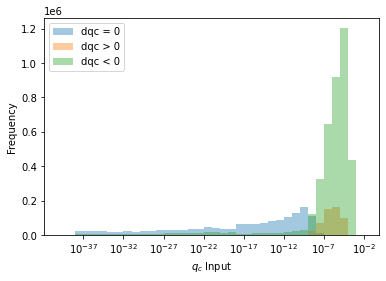

In [10]:
tz = mp_data["qctend_TAU"]== 0
tp = mp_data["qctend_TAU"]> 0
tn = mp_data["qctend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["QC_TAU_in"][tz], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc = 0")
plt.hist(mp_data["QC_TAU_in"][tp], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc > 0")
plt.hist(mp_data["QC_TAU_in"][tn], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc < 0")

plt.gca().set_xscale("log")
plt.xlabel("$q_c$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("qc_tendency_properties.png")
#plt.gca().set_yscale("log")

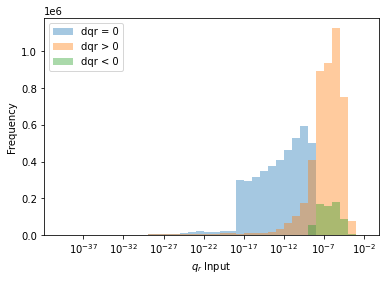

In [68]:
tz = mp_data["qrtend_TAU"]== 0
tp = mp_data["qrtend_TAU"]> 0
tn = mp_data["qrtend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["QR_TAU_in"][tz], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr = 0")
plt.hist(mp_data["QR_TAU_in"][tp], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr > 0")
plt.hist(mp_data["QR_TAU_in"][tn], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr < 0")

plt.gca().set_xscale("log")
plt.xlabel("$q_r$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("qr_tendency_properties.png")
#plt.gca().set_yscale("log")

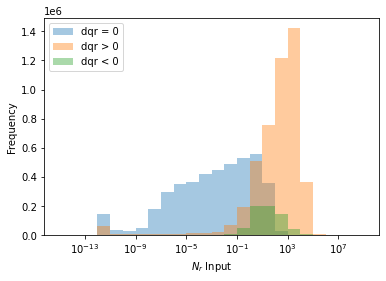

In [69]:
tz = mp_data["qrtend_TAU"]== 0
tp = mp_data["qrtend_TAU"]> 0
tn = mp_data["qrtend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["NR_TAU_in"][tz], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr = 0")
plt.hist(mp_data["NR_TAU_in"][tp], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr > 0")
plt.hist(mp_data["NR_TAU_in"][tn], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr < 0")

plt.gca().set_xscale("log")
plt.xlabel("$N_r$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("nr_tendency_properties.png")

Test mass conservation (mass diff should be 0). A significant proportion of grid cells have mass conserved

In [70]:
ix = (mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_mass_data = mp_data.loc[ix]

In [10]:
mp_mass_data.shape[0] / mp_data.shape[0]

0.5634467095451523

In [73]:
input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "lcldm", "precip_frac"]
output_cols = ["QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]
scale_in = StandardScaler()
in_data = scale_in.fit_transform(np.log10(np.maximum(mp_mass_data[input_cols].values, 1e-38)))
out_data_raw = mp_mass_data[output_cols].values
out_data_log = np.log10(np.maximum(out_data_raw, 1e-38))

In [42]:
(np.log10(1e-6) - np.log10(0.5e-5)) ** 2

0.4885590669614941

In [91]:
from tensorflow.experimental.numpy import log10 as tflog10
def mass_loss(y_true_log, y_pred_log, scale_factor=2):
    
    y_true = 10 ** y_true_log
    y_pred = 10 ** y_pred_log
    mse_loss = tf.reduce_mean((y_true_log - y_pred_log) ** 2, axis=0)
    mass_in_true_l = tflog10(tf.reduce_sum(y_true[:, 0:2], axis=1))
    mass_out_pred_l = tflog10(tf.reduce_sum(y_pred[:, 2:4], axis=1))
    mass_in_pred_l = tflog10(tf.reduce_sum(y_pred[:, 0:2], axis=1))

    mass_diff_loss = tf.reduce_mean(tf.abs(mass_in_true_l - mass_out_pred_l))
    mass_diff_loss += tf.reduce_mean(tf.abs(mass_in_true_l - mass_in_pred_l))
    loss = tf.reduce_sum(mse_loss) + scale_factor * mass_diff_loss
    loss = tf.reduce_sum(mse_loss)
    return loss

In [74]:
mod = Sequential()
mod.add(Dense(64, input_shape=(len(input_cols),)))
mod.add(Activation("relu"))
mod.add(Dense(len(output_cols)))

In [75]:
mod.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
mod.fit(in_data, out_data_log, epochs=30, batch_size=1024, verbose=1)

Epoch 1/30
5308/5308 [==============================] - 4s 614us/step - loss: 33.9877
Epoch 2/30
5308/5308 [==============================] - 3s 612us/step - loss: 1.1305
Epoch 3/30
5308/5308 [==============================] - 3s 618us/step - loss: 0.3799
Epoch 4/30
5308/5308 [==============================] - 3s 610us/step - loss: 0.2088
Epoch 5/30
5308/5308 [==============================] - 3s 610us/step - loss: 0.1545
Epoch 6/30
5308/5308 [==============================] - 3s 609us/step - loss: 0.1322
Epoch 7/30
5308/5308 [==============================] - 3s 612us/step - loss: 0.1170
Epoch 8/30
5308/5308 [==============================] - 3s 618us/step - loss: 0.1087
Epoch 9/30
5308/5308 [==============================] - 3s 613us/step - loss: 0.1016
Epoch 10/30
5308/5308 [==============================] - 3s 613us/step - loss: 0.0960
Epoch 11/30
5308/5308 [==============================] - 3s 611us/step - loss: 0.0902
Epoch 12/30
5308/5308 [==============================] - 3s 61

In [64]:
# Slow manual training loop. Only use for debugging

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
train_dataset = tf.data.Dataset.from_tensor_slices((in_data.astype("float32"), 
                                                    out_data_log.astype("float32")))
for epoch in range(30):
    train_dataset = train_dataset.shuffle(buffer_size=4096).batch(4096)
    print("Epoch", epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            outs = mod(x_batch_train)
            loss_val = mass_loss(y_batch_train, outs)
        grads = tape.gradient(loss_val, mod.trainable_weights)
        optimizer.apply_gradients(zip(grads, mod.trainable_weights))
    print(loss_val)


Epoch 0


KeyboardInterrupt: 

In [76]:
mp_test_data = pd.read_csv(mp_csv_files[600])
dt = 60 * 30 #minutes
for var in ["QC", "QR", "NC", "NR"]:
    mp_test_data[var + "_TAU_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_TAU"] * dt)
    mp_test_data[var + "_MG2_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_MG2"] * dt)
mp_test_data["tend_diff_TAU"] = (mp_test_data["qctend_TAU"] + mp_test_data["qrtend_TAU"])
mp_test_data["mass_diff_TAU"] = (mp_test_data["QC_TAU_out"] + mp_test_data["QR_TAU_out"]) - (mp_test_data["QC_TAU_in"] + mp_test_data["QR_TAU_in"])

ixt = (mp_test_data["tend_diff_TAU"] == 0) & (mp_test_data["mass_diff_TAU"] == 0) & \
    np.all(mp_test_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_test_mass_data = mp_test_data.loc[ixt]

in_test_data = scale_in.transform(np.log10(np.maximum(mp_test_mass_data[input_cols].values, 1e-38)))
out_test_data = np.log10(np.maximum(mp_test_mass_data[output_cols].values, 1e-38))

In [77]:

mod_preds = mod.predict(in_test_data, batch_size=1024)

In [82]:
from sklearn.metrics import r2_score
for i in range(3):
    print(output_cols[i], r2_score(out_test_data[:, i], mod_preds[:, i]))

QR_TAU_out 0.9961725387360374
NC_TAU_out 0.9998764916888067
NR_TAU_out 0.9971265279935481


In [39]:
mod_preds[:, 0].min()

-38.158497

In [42]:
mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1).max()

0.0006223325764726

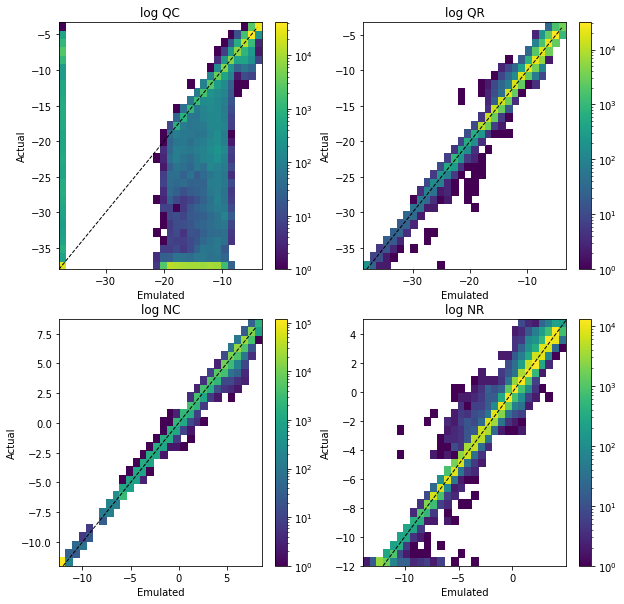

In [86]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(2, 2, i + 2)
    plt.hist2d(mod_preds[:, i], out_test_data[:,i], cmin=1, norm=LogNorm(), bins=30)
    plt.xlabel("Emulated")
    plt.ylabel("Actual")
    plt.title("log " + output_cols[i].split("_")[0])
    diag = np.arange(out_test_data[:, i].min(), out_test_data[:, i].max(), 1)
    plt.plot(diag, diag, 'k--', lw=1)
    plt.colorbar()
plt.subplot(2, 2, 1)
qc_out = np.log10(np.maximum(mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1) - 10 ** mod_preds[:, 0], 1e-38))
_ = plt.hist2d(qc_out, np.log10(np.maximum(mp_test_mass_data["QC_TAU_out"], 1e-38)), cmin=1, norm=LogNorm(), bins=30)
plt.xlabel("Emulated")
plt.ylabel("Actual")
diag = np.arange(-38, -3, 1)
plt.plot(diag, diag, 'k--', lw=1)
plt.colorbar()
plt.title("log QC")
plt.savefig("mass_hist_out.png", dpi=200, bbox_inches="tight")

In [46]:
qmass_in = np.log10(np.maximum(mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1), 1e-38))

(array([2.5200e+02, 3.1000e+01, 3.5000e+01, 5.1000e+01, 6.5000e+01,
        6.1000e+01, 7.7000e+01, 1.1500e+02, 1.2700e+02, 1.8100e+02,
        2.8600e+02, 4.1900e+02, 9.0400e+02, 1.2470e+03, 6.4400e+02,
        8.0000e+02, 1.0270e+03, 1.3441e+04, 1.5858e+04, 1.6750e+04,
        1.7771e+04, 1.9332e+04, 2.0478e+04, 2.3406e+04, 2.7231e+04,
        3.1745e+04, 2.7063e+04, 2.9885e+04, 2.5208e+04, 5.0600e+02]),
 array([-38.        , -36.84019937, -35.68039874, -34.52059811,
        -33.36079749, -32.20099686, -31.04119623, -29.8813956 ,
        -28.72159497, -27.56179434, -26.40199372, -25.24219309,
        -24.08239246, -22.92259183, -21.7627912 , -20.60299057,
        -19.44318995, -18.28338932, -17.12358869, -15.96378806,
        -14.80398743, -13.6441868 , -12.48438617, -11.32458555,
        -10.16478492,  -9.00498429,  -7.84518366,  -6.68538303,
         -5.5255824 ,  -4.36578178,  -3.20598115]),
 <BarContainer object of 30 artists>)

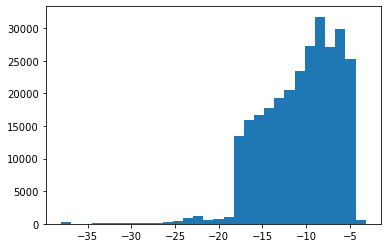

In [85]:
plt.hist(np.log10(np.maximum(mp_test_mass_data["QR_TAU_in"], 1e-38,)), bins=30)

In [28]:
ds = xr.open_dataset("/glade/p/cisl/aiml/dgagne/TAU_run5_full/TAU_run5.cam.h1.0002-06-16-21600.nc")

In [29]:
ds["QT_TAU_in"] = ds["QR_TAU_in"] + ds["QC_TAU_in"]

In [107]:
dt = 1
ds["QR_TAU_out"] = ds["QR_TAU_in"] + dt * ds["qrtend_TAU"]
ds["QC_TAU_out"] = ds["QC_TAU_in"] + dt * ds["qctend_TAU"]
ds["NR_TAU_out"] = ds["NR_TAU_in"] + dt * ds["nrtend_TAU"]
ds["NC_TAU_out"] = ds["NC_TAU_in"] + dt * ds["nctend_TAU"]

In [31]:
ds["QT_TAU_out"] = ds["QR_TAU_out"] + ds["QC_TAU_out"]

In [32]:
ds["mass_diff"] = ds["QT_TAU_in"] - ds["QT_TAU_out"]

In [33]:
mass_diff_vals = ds["mass_diff"].values.ravel()

In [108]:
np.count_nonzero(np.logical_and(ds["QC_TAU_in"] > 0, ds["QC_TAU_out"] >= 0)) / np.count_nonzero(ds["QC_TAU_in"] > 0)

0.9685929659188537

In [35]:
np.count_nonzero(mass_diff_vals == 0) / mass_diff_vals.size

0.9771775422272859

In [36]:
np.count_nonzero(ds["qrtend_TAU"] + ds["qctend_TAU"] == 0) / mass_diff_vals.size

0.9322071405104649

In [42]:
qr = ds["NR_TAU_in"].values
qr[qr > 0].min()

1e-12

In [61]:
np.count_nonzero(np.logical_and((ds["QC_TAU_in"] > 0), (ds["QR_TAU_in"] == 0))) / ds["QC_TAU_in"].size

0.0007707572277681328

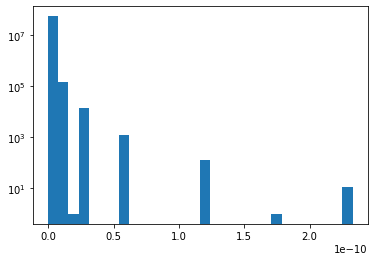

In [37]:
plt.hist(np.abs(mass_diff_vals), bins=30)
plt.gca().set_yscale("log")

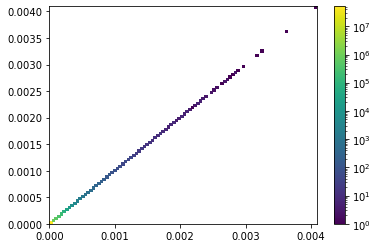

In [38]:
plt.hist2d(ds["QT_TAU_in"].values.ravel(), ds["QT_TAU_out"].values.ravel(), bins=100, cmin=1, norm=LogNorm())
plt.colorbar()

In [91]:
qr_orig = np.log10(np.maximum(ds["QR_TAU_in"].values.ravel(), 1e-38))

(array([ 755932.,  789581.,  465151.,  414486.,  182812.,  260760.,
         485545.,  579836., 1532863., 1142724.,  368730.,  485590.,
         786688., 1413532., 3168386.,  543705.,  615184.,  755780.,
         740132.,  453738.,  445334.,  474292.,  522459.,  578050.,
         644857.,  772637.,  935316., 1142088., 1455270., 1652457.,
        1796926., 2289931.]),
 array([-37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5]),
 <BarContainer object of 32 artists>)

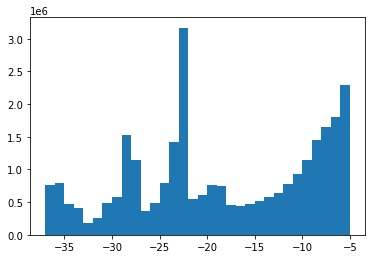

In [92]:
plt.hist(qr_orig, bins=np.arange(-37, -4, 1))